In [122]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
import time
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df_present = pd.read_csv('../../Dataset/air_system_present_year.csv')
df_previous = pd.read_csv('../../Dataset/air_system_previous_years.csv')

# Selected columns based on visual correlations
selected_columns = [
    'ag_005', 'az_005', 'ba_000', 'bb_000', 'bx_000', 'bu_000', 'bv_000', 
    'cc_000', 'ci_000', 'cn_004', 'cn_005', 'cq_000', 'cs_005', 
    'ee_002', 'ee_003', 'ee_004', 'ad_000'
]

In [123]:
# CALCULATE real values and  predict values custs, for statical comparsion
def calcular_custo_com_modelo(y_true, y_pred):
    tp = ((y_pred == 1) & (y_true == 1)).sum() #true-positive
    fp = ((y_pred == 1) & (y_true == 0)).sum() #false-positive
    fn = ((y_pred == 0) & (y_true == 1)).sum() #false-negative

    custo_total = (tp * 25) + (fp * 10) + (fn * 500)
    return custo_total

# Take the mean of columns
mean_previous = df_previous.apply(pd.to_numeric, errors='coerce').mean()
mean_present = df_present.apply(pd.to_numeric, errors='coerce').mean()

# Replace 'na'
df_previous = df_previous.apply(lambda x: x.replace('na', mean_previous[x.name]) if x.name in mean_previous.index else x)
df_present = df_present.apply(lambda x: x.replace('na', mean_present[x.name]) if x.name in mean_present.index else x)

# Tratament Class to Binary Boolean
df_previous['class_binary'] = df_previous['class'].apply(lambda x: 1 if x == 'pos' else 0)
df_present['class_binary'] = df_present['class'].apply(lambda x: 1 if x == 'pos' else 0)


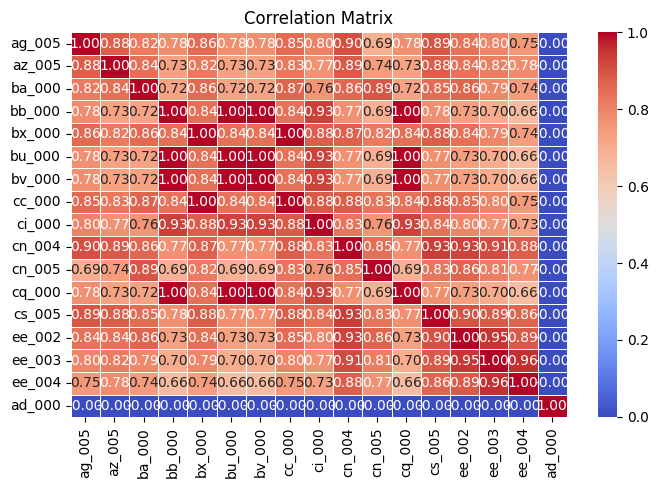

In [124]:
# # I started here for understanding the importance of columns and their weights
# numeric_cols = df_previous.select_dtypes(include='number')
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=numeric_cols.T, orient='v')
# plt.title('Boxplot Columns')
# plt.xticks(rotation=90)
# # plt.savefig('boxplot_columns.png')
# plt.show()

# Methods that used to view temperature for columns pos filtering with most importance and weight for Predict Train
# obs: yes, the column ad_000 helps to increase result
df_selected = df_previous[selected_columns]
correlation_matrix = df_selected.corr()
plt.figure(figsize=(8, 5)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
# plt.savefig('correlation_columns.png')
plt.show() 

In [125]:
# Separate feature columns from target columns
X = df_previous[selected_columns]
y = df_previous['class_binary']
X_present = df_present[selected_columns]
y_present = df_present['class_binary']

# Split data size 0.2 to test and 0.8 to train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to reduce unbalanced classes between low positive cases
smote = SMOTE(random_state=64)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardized data processing
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)
X_present = scaler.transform(X_present)

In [126]:
# # When using this randomization, it is not necessary to use the next RUN cell. The next cell is used when the parameter values are defined.
# # Parameters range for random search
# param_dist = {
#     'n_estimators': randint(30, 400),
#     'max_depth': randint(1, 200),
#     'min_samples_split': randint(2, 30),
#     'min_samples_leaf': randint(1, 8),
# }

# # For security not lost values, sabe the best params in .txt
# best_params_file = '../../results/best_params.txt'

# def save_best_params(best_params, runtime):
#     with open(best_params_file, 'w') as file:
#         file.write(f"Best hyperparams:\n{best_params}\n")
#         file.write(f"Total time run: {runtime:.2f} segundos")

# # Create RandomizedSearchCV Object
# random_search = RandomizedSearchCV(
#     estimator=RandomForestClassifier(random_state=32), 
#     param_distributions=param_dist, 
#     n_iter=40,
#     scoring='recall',
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# # Fit the model using random search
# start_time = time.time()
# random_search.fit(X_train_resampled, y_train_resampled)
# elapsed_time = time.time() - start_time

# # Get the best model and final hyperparams
# best_model = random_search.best_estimator_
# best_params = random_search.best_params_

# print("Best finally found hyperparams:", best_params)
# save_best_params(best_params, elapsed_time)

In [127]:
# # WHO IS THE BEST?
# params_list = [
#     {'max_depth': 216, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 324},
#     {'max_depth': 91, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 506},
#     {'max_depth': 93, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 336}
# ]

# best_f1_score = 0.0
# best_params = None

# for i, params in enumerate(params_list):
#     model = RandomForestClassifier(**params, random_state=64, verbose=2)
#     model.fit(X_train_resampled, y_train_resampled)
#     y_pred = model.predict(X_test)
    
#     f1 = f1_score(y_test, y_pred)
#     print(f"F1-score para o modelo {i+1}: {f1}")
    
#     if f1 > best_f1_score:
#         best_f1_score = f1
#         best_params = params

# print("\nBest model found:")
# print(f"Params: {best_params}")
# print(f"Best F1-score: {best_f1_score}")

In [128]:
# These parameters are hard-coded, obtained from randomization. To visualize detailed iterations, change verbose to 2.
# These parameters are a copy of the best_params, the best result found from the randomizer. Check ../../results and {paste}/{copy here} to test other best parameters found.
# For multiple process 'n_job = (number_of_paralels)'.

params = {'max_depth': 39, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 154} #40 iteration best param chosen (additional column)
# params = {'max_depth': 216, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 324} #50 iteration best param found
# params = {'max_depth': 91, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 506} #30 iteration best param found
# params = {'max_depth': 93, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 336} #20 iteration best param found

model = RandomForestClassifier(  **params, random_state=64, verbose=1, n_jobs=2)
model.fit(X_train_resampled, y_train_resampled)
print("Training completed.")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.4s


Training completed.


[Parallel(n_jobs=2)]: Done 154 out of 154 | elapsed:  1.1min finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 154 out of 154 | elapsed:    0.2s finished



Metric Eval Test Data:
Accuracy: 0.983
Precision: 0.5125
Recall: 0.7735849056603774
F1-Score: 0.6165413533834586
ROC: 0.8801755542892997
Confusion Matrix (Teste):
 [[11632   156]
 [   48   164]]


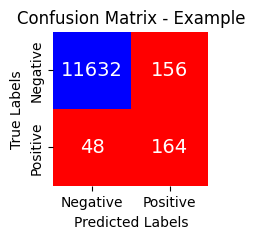

In [129]:
# Make predict
y_pred = model.predict(X_test)

# Evaluate test data
print("\nMetric Eval Test Data:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-Score: {f1_score(y_test, y_pred)}")
print(f"ROC: {roc_auc_score(y_test, y_pred)}")
print(f"Confusion Matrix (Teste):\n {confusion_matrix(y_test, y_pred)}") 

plt.figure(figsize=(2, 2))
cm = confusion_matrix(y_test, y_pred)
cmap_colors = ['red', 'blue']
sns.heatmap(cm, cmap=cmap_colors, annot=True, fmt='d', cbar=False,
            annot_kws={"size": 14}, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Example')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 154 out of 154 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s



Metric Preidct 'Present Year':
Accuracy: 0.9821261171176802
Precision: 0.6052009456264775
Recall: 0.6826666666666666
F1-Score: 0.6416040100250626
ROC: 0.8359896753274457
Confusion Matrix (Present Year):
 [[15459   167]
 [  119   256]]


[Parallel(n_jobs=2)]: Done 154 out of 154 | elapsed:    0.2s finished


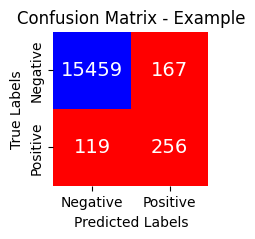

In [130]:
y_pred = model.predict(X_test)
y_pred_present = model.predict(X_present)

print("\nMetric Preidct 'Present Year':")
print(f"Accuracy: {accuracy_score(y_present, y_pred_present)}")
print(f"Precision: {precision_score(y_present, y_pred_present)}")
print(f"Recall: {recall_score(y_present, y_pred_present)}")
print(f"F1-Score: {f1_score(y_present, y_pred_present)}")
print(f"ROC: {roc_auc_score(y_present, y_pred_present)}")
print(f"Confusion Matrix (Present Year):\n {confusion_matrix(y_present, y_pred_present)}")

plt.figure(figsize=(2, 2))
cm = confusion_matrix(y_present, y_pred_present)
cmap_colors = ['red', 'blue']
sns.heatmap(cm, cmap=cmap_colors, annot=True, fmt='d', cbar=False,
annot_kws={"size": 14}, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Example')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [131]:
# # Function to calculate the maintenance cost based on the determined actions
# def calcular_custo_maintenance(df):
#     cost_now = 25
#     cost_maybe = 10
#     cost_not_now = 500

#     df['maintenance_action'] = pd.cut(df['predict_class'], bins=[-np.inf, 0.35, 0.7, np.inf], 
#                                        labels=['no_maintenance', 'maybe_needed', 'maintenance_now'])

#     df['maintenance_cost'] = df['maintenance_action'].map({
#         'maintenance_now': cost_now,
#         'maybe_needed': cost_maybe,
#         'no_maintenance': cost_not_now
#     }).fillna(cost_not_now).astype(int)

#     return df

# # Function to calculate the original maintenance cost based on the original class
# def calculate_original_cost(class_value):
#     if class_value == 1:
#         return 25
#     elif class_value == 0:
#         return 500
#     else:
#         return np.nan

# # Create output DataFrame
# df_saida = pd.DataFrame({
#     'id_truck': df_present.index,
#     'predict_class': y_pred_present,
#     'class_binary': df_present['class_binary']
# })

# # Calculate original costs and maintenance costs using predictions
# df_saida['original_cost'] = df_saida['class_binary'].apply(calculate_original_cost)
# df_saida = calcular_custo_maintenance(df_saida)

# # Create 'predict_class_binary' column based on the threshold
# threshold = 0.5  
# df_saida['predict_class_binary'] = df_saida['predict_class'].apply(lambda x: 1 if x >= threshold else 0)

# # Adjust maintenance costs for 'maybe_needed' cases
# df_saida['maintenance_cost'] = np.where(df_saida['predict_class_binary'] == 0, 10, df_saida['maintenance_cost'])

# # Display trucks needing maintenance
# maintenance_trucks = df_saida[df_saida['maintenance_action'] != 'no_maintenance'][['id_truck', 'class_binary', 'predict_class', 'maintenance_action', 'maintenance_cost', 'original_cost']].head(50)
# print("Trucks needing maintenance:")
# display(maintenance_trucks)

# # Verify counts of predicted and actual maintenance needs
# count_pred = np.bincount(y_pred_present)
# count_present = np.bincount(y_present)
# difference = count_pred - count_present

# print("\nDirect count from 'present year' and 'predict present year' maintenance trucks: \n")
# print(f"* Present_year_real_values: {count_present[0]} neg and {count_present[1]} pos.")
# print(f"* Present_year_pred_values: {count_pred[0]} neg and {count_pred[1]} pos.\n")
# print(f"-------------- * Difference: {difference[0]} neg and {difference[1]} pos. \n")

In [132]:
# Function to calculate maintenance cost based on determined actions
def calculate_maintenance_cost(df):
    cost_now = 25
    cost_maybe = 10
    cost_not_now = 500

    df['maintenance_action'] = pd.cut(df['predict_class'], bins=[-np.inf, 0.4, 0.7, np.inf], 
                                      labels=['no_maintenance', 'maybe_needed', 'maintenance_now'])

    df['maintenance_cost'] = df['maintenance_action'].map({
        'maintenance_now': cost_now,
        'maybe_needed': cost_maybe,
        'no_maintenance': cost_not_now
    }).fillna(cost_not_now).astype(int)

    return df

# Function to calculate original maintenance cost based on the original class
def calculate_original_cost(class_value):
    if class_value == 1:
        return 500
    elif class_value == 0:
        return 25
    else:
        return np.nan

# Create output DataFrame
df_output = pd.DataFrame({
    'truck_id': df_present.index,
    'predict_class': np.random.rand(len(df_present)),
    'class_binary': df_present['class_binary']
})

# Calculate original and maintenance costs using predictions
df_output['original_cost'] = df_output['class_binary'].apply(calculate_original_cost)
df_output = calculate_maintenance_cost(df_output)

# Create a new column 'predict_class_binary' with a threshold of 0.4 to maybe_needed alert
df_output['predict_class_binary'] = (df_output['predict_class'] >= 0.4).astype(int)

# Filter only examples where class_binary is equal to 1
df_class_1 = df_output[df_output['class_binary'] == 1]

# Select 50 random examples of trucks needing maintenance among those with class_binary equal to 1
maintenance_trucks = df_class_1[df_class_1['maintenance_action'] != 'no_maintenance'][
    ['truck_id', 'predict_class', 'predict_class_binary','class_binary', 'maintenance_action', 'maintenance_cost', 'original_cost']
].sample(n=50, random_state=42)

print("List for comparison of positives, preventive and predicted cases:")
display(maintenance_trucks)

# Verify counts of predicted and actual maintenance needs
count_pred = np.bincount(y_pred_present)
count_present = np.bincount(y_present)
difference = count_pred - count_present

print("\nDirect count from 'present year' and 'predict present year' maintenance trucks: \n")
print(f"* Present_year_real_values: {count_present[0]} neg and {count_present[1]} pos.")
print(f"* Present_year_pred_values: {count_pred[0]} neg and {count_pred[1]} pos.\n")
print(f"-------------- * Difference: {difference[0]} neg and {difference[1]} pos. \n")

print("\nCount of predict_class_binary == 1 and class_binary == 1:")
print(f"Predicted maintenance needs: {count_pred[1]}  -> The 'maybe_needed' threshold of 0.4 also has a count of 1, as a prevent measure for maintenance. ")
print(f"Actual maintenance needs: {count_present[1]}")


List for comparison of positives, preventive and predicted cases:


,truck_id,predict_class,predict_class_binary,class_binary,maintenance_action,maintenance_cost,original_cost
14907,14907,0.485361,1,1,maybe_needed,10,500
15800,15800,0.402971,1,1,maybe_needed,10,500
9613,9613,0.785004,1,1,maintenance_now,25,500
12769,12769,0.716092,1,1,maintenance_now,25,500
854,854,0.840779,1,1,maintenance_now,25,500
7381,7381,0.967747,1,1,maintenance_now,25,500
13470,13470,0.585152,1,1,maybe_needed,10,500
5072,5072,0.488281,1,1,maybe_needed,10,500
14933,14933,0.891038,1,1,maintenance_now,25,500
9649,9649,0.494562,1,1,maybe_needed,10,500



Direct count from 'present year' and 'predict present year' maintenance trucks: 

* Present_year_real_values: 15626 neg and 375 pos.
* Present_year_pred_values: 15578 neg and 423 pos.

-------------- * Difference: -48 neg and 48 pos. 


Count of predict_class_binary == 1 and class_binary == 1:
Predicted maintenance needs: 423  -> The 'maybe_needed' threshold of 0.4 also has a count of 1, as a prevent measure for maintenance. 
Actual maintenance needs: 375
